<a href="https://colab.research.google.com/github/alexman128/Guadalajara/blob/master/niitest2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import glob
import cv2
import imageio

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image
from matplotlib.pyplot import figure

from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *
from fastai.vision.learner import unet_learner

In [4]:
#path = "/content/drive/MyDrive/TESIS/mri/smalldataset"
path = "/content/drive/MyDrive/TESIS/mri/mediumdataset"
data_path = os.path.join(path, 'images')
segmentation_path = os.path.join(path, 'segmentations')

data_path
segmentation_path

'/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations'

In [5]:
# Create a meta file for nii files processing

file_list = []
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        file_list.append((dirname, filename))

for dirname, _, filenames in os.walk(segmentation_path):
    for filename in filenames:
        file_list.append((dirname, filename))

df_files = pd.DataFrame(file_list, columns =['dirname', 'filename'])
df_files.sort_values(by=['filename'], ascending=True)

,dirname,filename
11,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-0.nii
12,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-1.nii
13,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-10.nii
14,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-2.nii
15,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-3.nii
16,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-4.nii
17,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-5.nii
18,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-6.nii
19,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-7.nii
20,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-8.nii


In [6]:
# Map CT scan and label

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"

    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = segmentation_path

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True)

df_files



,dirname,filename,mask_dirname,mask_filename
0,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-0.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-0.nii
1,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-1.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-1.nii
2,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-10.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-10.nii
3,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-2.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-2.nii
4,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-3.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-3.nii
5,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-4.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-4.nii
6,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-5.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-5.nii
7,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-6.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-6.nii
8,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-7.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-7.nii
9,/content/drive/MyDrive/TESIS/mri/mediumdataset/images,volume-8.nii,/content/drive/MyDrive/TESIS/mri/mediumdataset/segmentations,segmentation-8.nii


In [7]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [8]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


In [9]:


print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))



-3024.0 1410.0
0.0 2.0


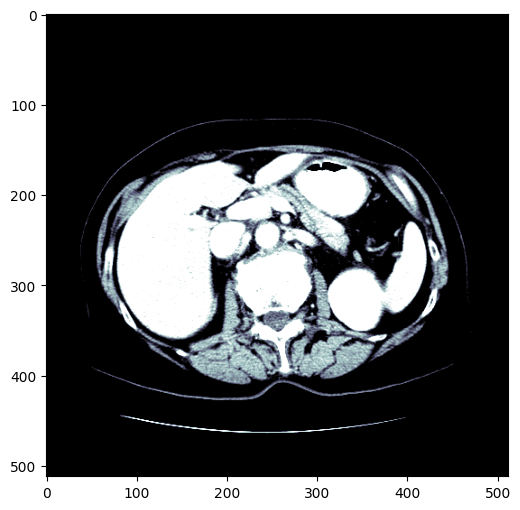

In [10]:
# Preprocess the nii file
# Source https://docs.fast.ai/medical.imaging

dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)

plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [11]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(20,16), dpi=100)

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    plt.axis('off')

    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')
    plt.axis('off')

    plt.show()

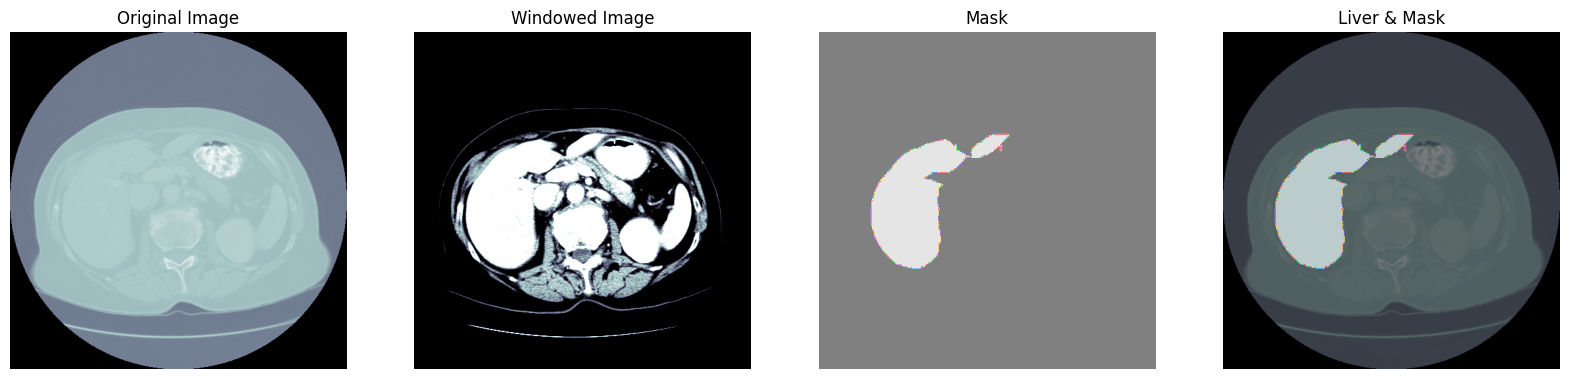

In [12]:


sample = 55

sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[..., sample],
             sample_mask[..., sample]])



In [13]:


# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print(np.array((unique, counts)).T)



[[     0 244111]
 [     1  18033]]


<Axes: >

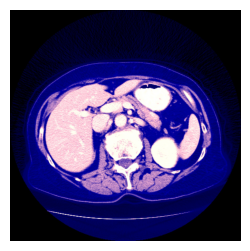

In [14]:
# Preprocessing functions
# Source https://docs.fast.ai/medical.imaging

class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)


@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=120):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

_,axs = subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver, dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0], figsize=(8, 6))

In [15]:
# Make custom JPG files for Unet training
# Total number of 131 nii files contains 67072 slices

GENERATE_JPG_FILES = True

if (GENERATE_JPG_FILES) :

    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim

        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    path = Path("../input/liver-segmentation-with-fastai-v2") # read jpg from saved kernel output

  0%|          | 0/4 [00:00<?, ?it/s]

In [16]:
BATCH_SIZE = 16
IMAGE_SIZE = 128

codes = np.array(["background","liver","tumor"])

def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]

db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(IMAGE_SIZE)],
               get_items=get_image_files,
               get_y=label_func)

ds = db.datasets(source=path/'train_images')

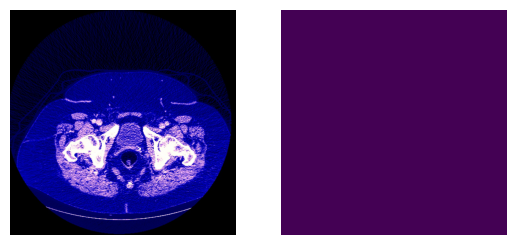

In [17]:
idx = 20
imgs = [ds[idx][0],ds[idx][1]]
fig, axs = plt.subplots(1, 2)

for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i])

In [18]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)

[[     0 262144]]


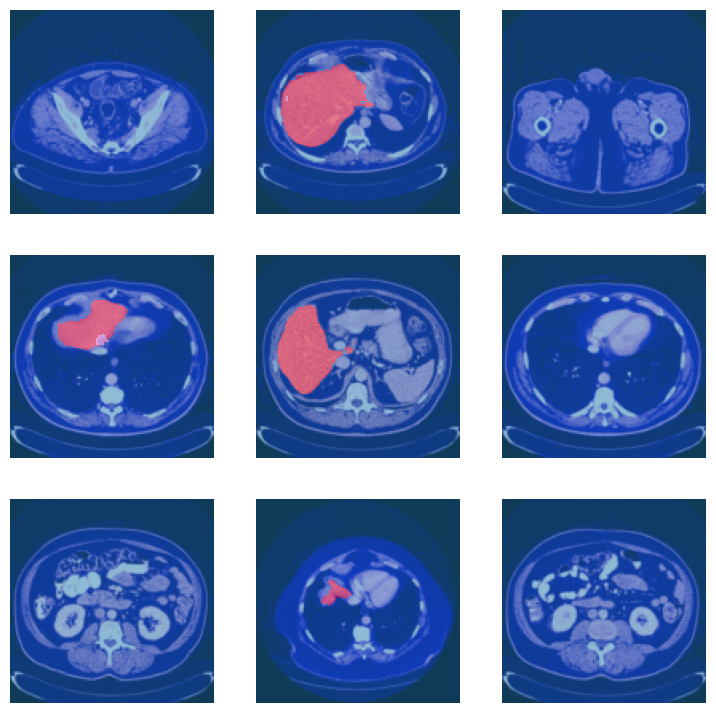

In [19]:
dls = db.dataloaders(path/'train_images', bs = BATCH_SIZE) #, num_workers=0
dls.show_batch()

In [20]:
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()

def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

In [21]:
learn = unet_learner(dls,
                     #resnet152,
                     resnet50,
                     loss_func=CrossEntropyLossFlat(axis=1),
                     metrics=[foreground_acc, cust_foreground_acc])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback() )

epoch,train_loss,valid_loss,foreground_acc,cust_foreground_acc,time


In [ ]:
learn.show_results()

In [ ]:
learn.save('/content/drive/MyDrive//TESIS/mri/liver_classifier')

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
#try:
interp = ClassificationInterpretation.from_learner(learn)
#except AttributeError:
#  pass